In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python easyocr pdf2image

# Install Detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://download.pytorch.org/whl/cu118
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-yohbhsav
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-yohbhsav
  Resolved https://github.com/facebookresearch/detectron2.git to commit 18f69583391e5040043ca4f4bebd2c60f0ebfde0
  Preparing metadata (setup.py) ... done


In [3]:
!pip install pdf2image
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [4]:
# !python -m pip install pyyaml==5.1
# import sys, os, distutils.core
# # Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# # See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))

# # Properly install detectron2. (Please do not install twice in both ways)
# # !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [5]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [6]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [26]:
from pdf2image import convert_from_path
from PIL import Image
import cv2

# If PDF, convert to image
pages = convert_from_path("/content/bickslow bank.pdf")
image = pages[0]  # First page
image.save("page.jpg")


In [27]:
import torch, torchvision
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

[07/26 10:46:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


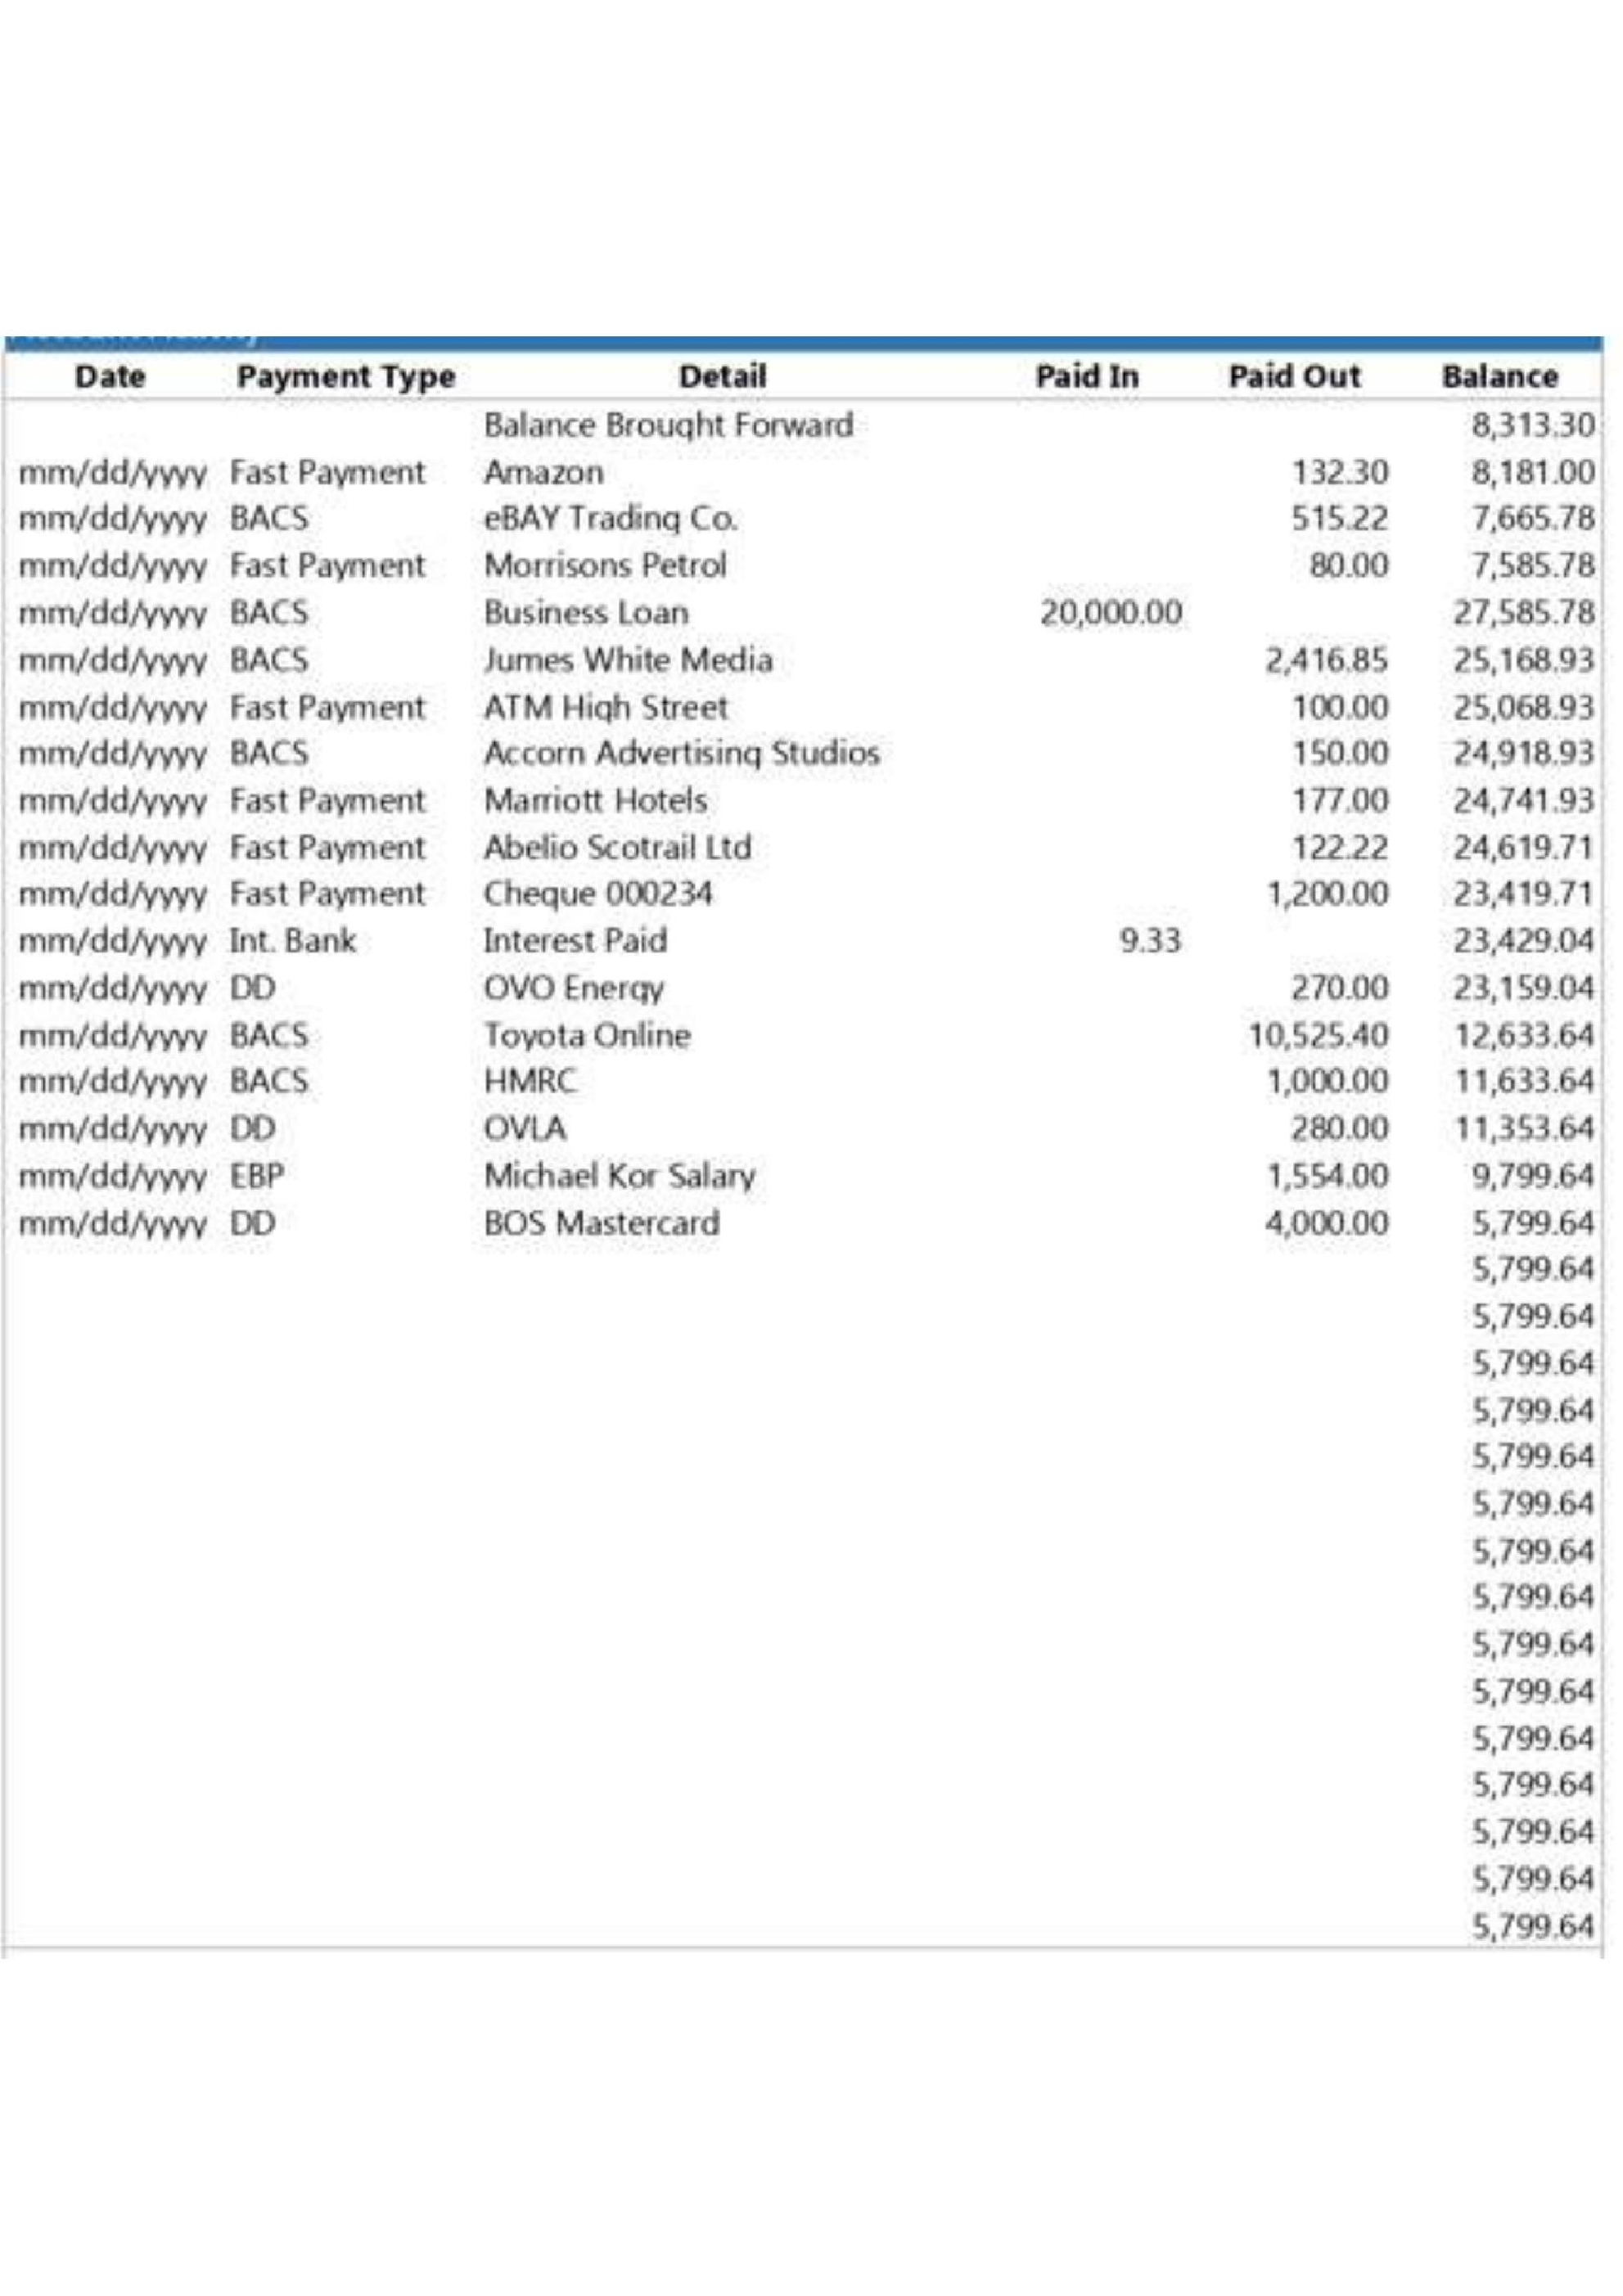

In [28]:
image = cv2.imread("page.jpg")
outputs = predictor(image)

# visualize the results
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get("coco_2017_train"), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [14]:
!wget https://raw.githubusercontent.com/detectron2/detectron2/main/configs/publaynet/faster_rcnn_R_50_FPN_3x.yaml -P /content/

--2025-07-26 10:40:02--  https://raw.githubusercontent.com/detectron2/detectron2/main/configs/publaynet/faster_rcnn_R_50_FPN_3x.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-26 10:40:02 ERROR 404: Not Found.



In [29]:
import easyocr
reader = easyocr.Reader(['en'])

boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()

cell_texts = []
for box in boxes:
    x1, y1, x2, y2 = map(int, box)
    cropped = image[y1:y2, x1:x2]
    result = reader.readtext(cropped)
    text = " ".join([item[1] for item in result])
    cell_texts.append((x1, y1, x2, y2, text))

In [30]:
import pandas as pd

# Sort top-to-bottom, then left-to-right
cell_texts.sort(key=lambda x: (x[1], x[0]))  # y1, then x1

# Group rows by y-coordinate proximity
rows = []
row = []
last_y = None
threshold = 20

for cell in cell_texts:
    y = cell[1]
    if last_y is None or abs(y - last_y) < threshold:
        row.append(cell[-1])
    else:
        rows.append(row)
        row = [cell[-1]]
    last_y = y
if row:
    rows.append(row)

# Save as DataFrame
df = pd.DataFrame(rows)
df.to_csv("bank_output.csv", index=False)
df.head()


""
